[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/constantinpape/torch-em/blob/main/experiments/2D-UNet-Training.ipynb)

# 2D UNet Training

This notebook implements training of a 2D UNet with `torch_em`. It implements training for affinity, boundary and foreground prediction. The training code is also customizable to enable training with a different target.

The sections of this notebook are organized s.t. there is a first cell that contains the configurable parameters. These cells are marked by the comment `#CONFIGURE ME`. The following cells contain code that do not need to be changed. But if you know what you're doing you can further customize the training there.

For setting up a local environment that can run `torch_em`, follow [the installation instructions](https://github.com/constantinpape/torch-em#installation). You can also run the notebook in google colab, please follow the instructions in the first section for this.

## Google Colab

Run the following cells if you are working in google colab. Skip them otherwise.

In [ ]:
# First, make sure that you are using a GPU. For this, go to:
# Runtime->Change runtime type and select Hardware accelarator->GPU
# When you then run this cell you should see a gpu status overview
# (if something went wrong you will see an error message)
!nvidia-smi

In [ ]:
# Install conda in your google drive session
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# update conda
!conda update conda

In [ ]:
# Use conda to install torch_em and its dependencies
!conda install -c conda-forge torch_em "pyyaml<5.0"

In [ ]:
# mount your google drive to permanently save data
from google.colab import drive
drive.mount("/content/gdrive")

## Imports

Import the required libraries, no need to change anything here.

In [ ]:
# load tensorboard extension
# we will need this later in the notebook to monitor the training progress
%load_ext tensorboard

In [1]:
import numpy as np
import torch.nn as nn
import torch_em
import torch_em.data.datasets as torchem_data
from torch_em.model import UNet2d
from torch_em.util.debug import check_loader, check_trainer

/g/kreshuk/yu/miniconda3/envs/torch-em/lib/python3.8/site-packages/bioimageio/spec/shared/_resolve_source.py:401: CacheWarning: found cached /tmp/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/g/kreshuk/yu/miniconda3/envs/torch-em/lib/python3.8/site-packages/bioimageio/spec/shared/_resolve_source.py:401: CacheWarning: found cached /tmp/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)


## Training Data

Choose the dataset for training. You have two options here: choose a preconfigured dataset or specify the filepaths to your training data.

For preconfigured datasets `torch_em` implements download and default pre-processing already. The following pre-configured datasets are currently available:
- `covid_if`: Cells imaged via immunofluorescence.
- `dsb`: Nuclei imaged via fluorescence.
- `hpa`: Data from the human protein atlas.
- `isbi2012`: Neural tissue imaged in electron microscopy.
- `livecell`: Cells imaged in phase-contrast microscopy.
- `vnc-mitos`: Mitochondria imaged in electron microscopy.

If you're unsure if one of these datasets is suitable for you, just select it and continue to `Check training data` with the default settings in the next sections. You will see example images from the data there.

You can also load the training data from local files. `torch_em` supports loading data from different formats, the two easiest options are:
- single images: store images and labels in two separate folder using a common image format such as png or tif. The corresponding data and label files should have the same filename.
    - set `data_paths` to the filepath of the folder with the images, `label_paths` to the path of the folder with the labels
    - set `data_key` and `label_key` to `*.<FILE_EXTENSION>`, e.g. `*.tif` for tif files.
- image stacks: store the image and label stack(s) as hdf5, zarr or n5 data.
    - set `data_paths` to the filepath of the image data stack and `label_paths` to the path of the label data stack; you can also provide a list of file paths if you have multiple stacks
    - set `data_key` and `label_key` to the corresponding paths in file.
    
You can find examples for the custom datasets in the comments below.

You also need to choose `patch_shape`, which determines the size of the patches used for training, here.

In [4]:
# CONFIGURE ME

#
# use a pre-configured dataset
#

# Specify a pre-configured dataset. Set to `None` in order to specify the training data via file-paths instead.
preconfigured_dataset = "covid_if"

# example: use the pre-configured `dsb` dataset
# preconfigured_dataset = "dsb"

# Where to download the training data (the data will be downloaded only once).
# If you work in google colab you may want to adapt this path to be on your google drive, in order
# to not loose the data after each session.
download_folder = f"./training_data/{preconfigured_dataset}"

#
# use a custom dataset
#

# Create a custom dataset from local data by specifiying the paths for training data, training labels
# as well as validation data and validation labels
train_data_paths = []
val_data_paths = []
data_key = ""
train_label_paths = []
val_label_paths = []
label_key = ""

# In addition you can also specify region of interests for training using the normal python slice syntax
train_rois = None
val_rois = None

# example 1: Use training raw data and labels stored as tif-images in separate folders.
# The example is formulated using the data from the `dsb` dataset.

# train_data_paths = "./training_data/dsb/train/images"
# val_data_paths = "./training_data/dsb/test/images"
# data_key = "*.tif"
# train_label_paths = "./training_data/dsb/train/masks"
# val_label_paths = "./training_data/dsb/test/masks"
# label_key = "*.tif"
# patch_shape = (256, 256)

# example 2: Use training data and labels stored as a single stack in an hdf5 file.
# This example is formulated using the data from the `vnc-mitos` dataset,
# which stores the raw data in `/raw` and the labels in `/labels/mitochondria`.
# Note that we use roi's here to get separate training and val data from the same file.
# train_data_paths etc. can also be lists in order to train from multiple stacks.

# train_data_paths = train_label_paths = val_data_paths = val_label_paths = "./training_data/vnc-mitos/vnc_train.h5"
# data_key = "/raw"
# label_key = "/labels/mitochondria"
# train_rois = np.s_[:18, :, :]
# val_rois = np.s_[18:, :, :]
# patch_shape = (1, 512, 512)

#
# choose the patch shape
#

# This should be chosen s.t. it is smaller than the smallest image in your training data.
# If you are training from 3d data (data with a z-axis), you will need to specify the patch_shape
# as (1, shape_y, shape_x).
patch_shape = (512, 512)

In [5]:
dataset_names = [
    "covid_if", "dsb", "hpa", "isbi2012", "livecell", "vnc-mitos"
]


def check_data(data_paths, label_paths, rois):
    print("Loading the raw data from:", data_paths, data_key)
    print("Loading the labels from:", label_paths, label_key)
    try:
        torch_em.default_segmentation_dataset(data_paths, data_key, label_paths, label_key, patch_shape, rois=rois)
    except Exception as e:
        print("Loading the dataset failed with:")
        raise e

if preconfigured_dataset is None:
    print("Using a custom dataset:")
    print("Checking the training dataset:")
    check_data(train_data_paths, train_label_paths, train_rois)
    check_data(val_data_paths, val_label_paths, val_rois)
else:
    assert preconfigured_dataset in dataset_names, f"Invalid pre-configured dataset: {preconfigured_dataset}, choose one of {dataset_names}."
    if preconfigured_dataset in ("isbi2012", "vnc-mitos") and len(patch_shape) == 2:
        patch_shape = (1,) + patch_shape

assert len(patch_shape) in (2, 3)

## Network output

Choose the transformations applied to your label data in order to generate the network target data. If your labels can be fed to the network directly you don't need to do anything here. Otherwise, you can choose between the following transformations:
- `foreground`: transforms labels into a binary target
- `affinities`: transforms labels into affinity target
- `boundaries`: transforms labels into boundary target

Note that `affinities` and `boundaries` are mutually exclusive; `foreground` can be combined with the two other transformations. All three transformations are implemented to be applied to *instance labels*. See the screenshot below for an illustration of the expected input and the result of these transformations. You will see their result for your own datain in `Check training data`.

![targets](misc/targets.png)

In [6]:
# CONFIGURE ME

# Whether to add a foreground channel (1 for all labels that are not zero) to the target.
foreground = False
# Whether to add affinity channels (= directed boundaries) or a boundary channel to the target.
# Note that you can choose at most of these two options.
affinities = False
boundaries = False

# the pixel offsets that are used to compute the affinity channels
offsets = [[-1, 0], [0, -1], [-3, 0], [0, -3], [-9, 0], [0, -9]]

In [7]:
assert not (affinities and boundaries), "Predicting both affinities and boundaries is not supported"

label_transform, label_transform2 = None, None
if affinities:
    label_transform2 = torch_em.transform.label.AffinityTransform(
        offsets=offsets, add_binary_target=foreground, add_mask=True
    )
elif boundaries:
    label_transform = torch_em.transform.label.BoundaryTransform(
        add_binary_target=foreground
    )
elif foreground:
    label_transform = torch_em.transform.label.labels_to_binary

## Loss, metric & batch size

Choose important training parameters:

- `loss`: the loss function; can be one of `"bce", "ce", "dice"` (binary cross entropy, cross entropy, dice) or a torch module
- `metric`: the metric used for the validation data; same options as for `loss`
- `batch_size`: the training batch size

If you're unsure about these settings just use the default values, they are probably ok.

In [8]:
# CONFIGURE ME
batch_size = 1
loss = "dice"
metric = "dice"

In [25]:
#================== SUMMER SCHOOL ==================#

def dice_score(input_, target, eps=1e-7):
    numerator = (input_ * target).sum()
    denominator = (input_ * input_).sum() + (target * target).sum()
    score = 2. * (numerator / denominator.clamp(min=eps))
    return score

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, input_, target):
        return dice_score(input_, target, eps=self.eps)

loss_function = DiceLoss()
metric_function = DiceLoss()

In [26]:
kwargs = dict(
    ndim=2, patch_shape=patch_shape, batch_size=batch_size,
    label_transform=label_transform, label_transform2=label_transform2
)
ds = preconfigured_dataset

if ds is None:
    train_loader = torch_em.default_segmentation_loader(
        train_data_paths, data_key, train_label_paths, label_key,
        rois=train_rois, **kwargs
    )
    val_loader = torch_em.default_segmentation_loader(
        val_data_paths, data_key, val_label_paths, label_key,
        rois=val_rois, **kwargs
    )
else:
    kwargs.update(dict(download=True))
    if ds == "covid_if":
        # use first 5 images for validation and the rest for training
        train_range, val_range = (5, None), (0, 5)
        train_loader = torchem_data.get_covid_if_loader(download_folder, sample_range=train_range, **kwargs)
        val_loader = torchem_data.get_covid_if_loader(download_folder, sample_range=val_range, **kwargs)
    elif ds == "dsb":
        train_loader = torchem_data.get_dsb_loader(download_folder, split="train", **kwargs)
        val_loader = torchem_data.get_dsb_loader(download_folder, split="train", **kwargs)
    elif ds == "hpa":
        train_loader = torchem_data.get_hpa_segmentation_loader(download_folder, split="train", **kwargs)
        val_loader = torchem_data.get_hpa_segmentation_loader(download_folder, split="val", **kwargs)
    elif ds == "isbi2012":
        assert not foreground, "Foreground prediction for the isbi neuron segmentation data does not make sense, please change these setings"
        train_roi, val_roi = np.s_[:28, :, :], np.s_[28:, :, :]
        train_loader = torchem_data.get_isbi_loader(download_folder, rois=train_roi, **kwargs)
        val_loader = torchem_data.get_isbi_loader(download_folder, rois=val_roi, **kwargs)
    elif ds == "livecell":
        train_loader = torchem_data.get_livecell_loader(download_folder, split="train", **kwargs)
        val_loader = torchem_data.get_livecell_loader(download_folder, split="val", **kwargs)
    # monuseg is not fully implemented yet
    # elif ds == "monuseg":
    #     train_loader = torchem_data.get
    elif ds == "vnc-mitos":
        train_roi, val_roi = np.s_[:18, :, :], np.s_[18:, :, :]
        train_loader = torchem_data.get_vnc_mito_loader(download_folder, rois=train_roi, **kwargs)
        val_loader = torchem_data.get_vnc_mito_loader(download_folder, rois=val_roi, **kwargs)

assert train_loader is not None, "Something went wrong"
assert val_loader is not None, "Something went wrong"

/g/kreshuk/yu/miniconda3/envs/torch-em/lib/python3.8/site-packages/torch_em/data/datasets/util.py:72: UserWarning: ndim will be over-ridden in loader kwargs.
  warn(msg)


## Check training data

Check the output from your data loader. It consists of the input data for your network and the target data.
You should check that the target looks reasonable.

In [27]:
# CONFIGURE ME

# choose the number of samples to check per loader
n_samples = 4

Training samples


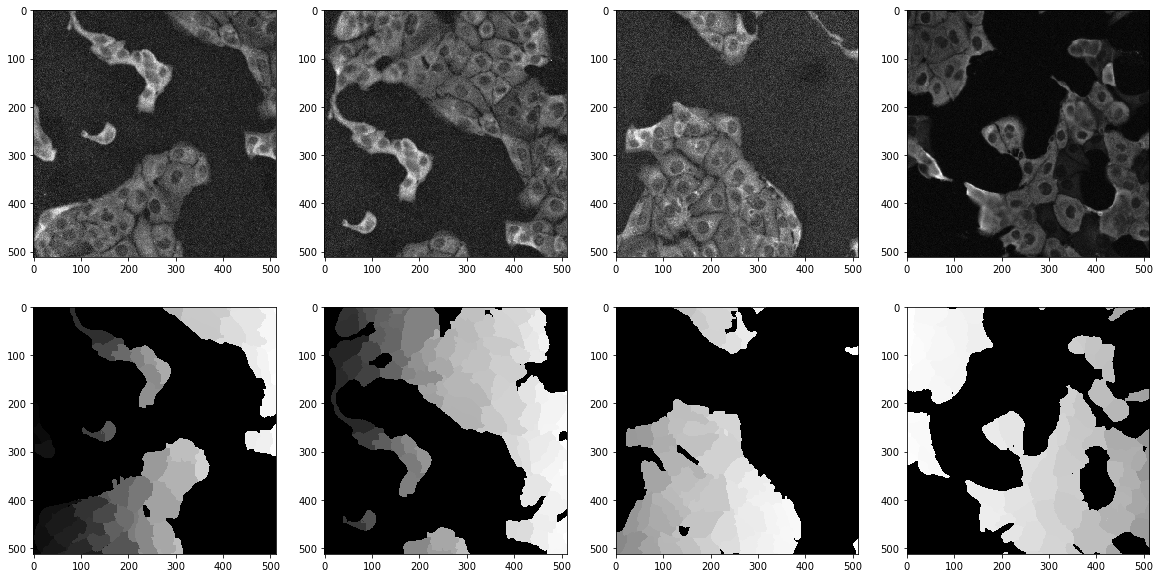

Validation samples


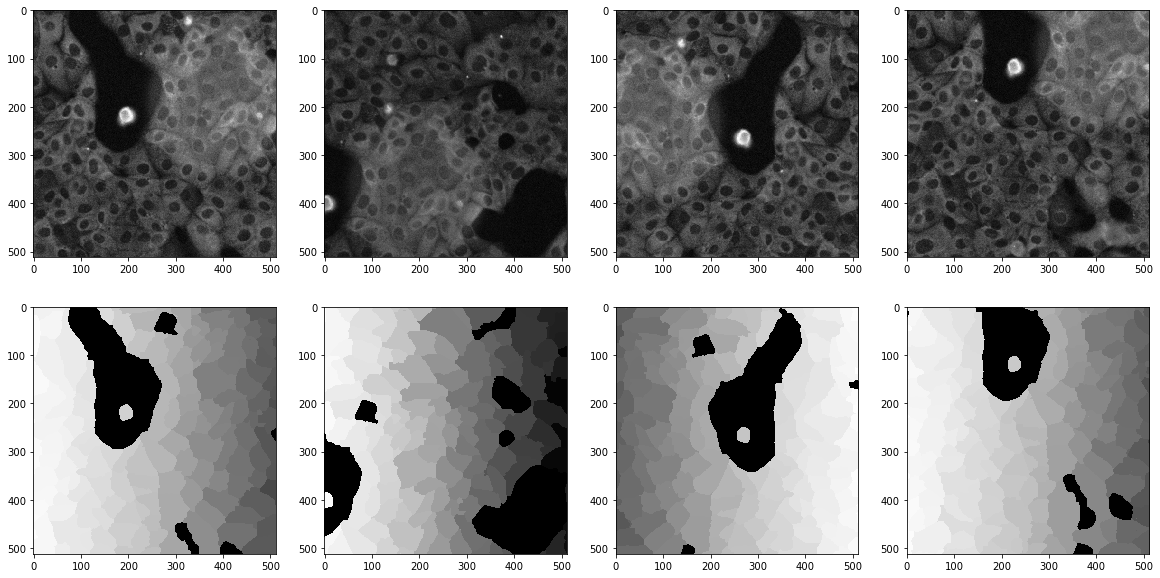

In [28]:
print("Training samples")
check_loader(train_loader, n_samples, plt=True)
print("Validation samples")
check_loader(val_loader, n_samples, plt=True)

## Network architecture

Choose the important network architecture parameters for the 2d UNet:
- `depth`: the number of decoder / encoder levels
- `initial_features`: the number of features in the first encoder level, the number will be doubled for each level
- `final_activation`: the activation applied to the UNet output
- `in_channels`: the number of input channels (= number of channels of the raw data)
- `out_channels`: the number of output channels (usually the number of target channels)

If you're unsure about these settings just use the default values, they are probably ok.

In [29]:
# CONFIGURE ME
depth = 4
initial_features = 32
final_activation = None

# If you leave the in/out_channels as None an attempt will be made to automatically deduce these numbers. 
in_channels = 2
out_channels = 2

In [30]:
if final_activation is None and loss == "dice":
    final_activation = "Sigmoid"
    print("Adding a sigmoid activation because we are using dice loss")

if in_channels is None:
    in_channels = 1

if out_channels is None:
    if affinities:
        n_off = len(offsets)
        out_channels = n_off + 1 if foreground else n_off
    elif boundaries:
        out_channels = 2 if foreground else 1
    elif foreground:
        out_channels = 1
    assert out_channels is not None, "The number of out channels could not be deduced automatically. Please set it manually in the cell above."

print("Creating 2d UNet with", in_channels, "input channels and", out_channels, "output channels.")
model = UNet2d(
    in_channels=in_channels, out_channels=out_channels, depth=depth, final_activation=final_activation
)

Adding a sigmoid activation because we are using dice loss
Creating 2d UNet with 2 input channels and 2 output channels.


## Tensorboard

Start the tensorboard in order to keep track of the training progress.

In [31]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## Training

Choose additional training parameter:
- `experiment_name`: the name for this training run, which will be used for naming the checkpoint for this model and for identifying the model in tensorboard.
- `n_iterations`: number of iterations to train for.
- `learning_rate`: the learning rate for gradient based updates.

This also starts the training!

**Important:** If you're on google colab the checkpoint will not be saved permanently. To save it you will need to copy the local folder `checkpoints` to your google drive.

In [32]:
# CONFIGURE ME
experiment_name = "my-shiny-net"
n_iterations = 10000
learning_rate = 1.0e-4

In [33]:
trainer = torch_em.default_segmentation_trainer(
    name=experiment_name, model=model,
    train_loader=train_loader, val_loader=val_loader,
    loss=loss_function, metric=metric_function,
    learning_rate=learning_rate,
    mixed_precision=True,
    log_image_interval=50
)
trainer.fit(n_iterations)

/g/kreshuk/yu/miniconda3/envs/torch-em/lib/python3.8/site-packages/torch_em/util/util.py:121: UserWarning: Constructor arguments for <class '__main__.DiceLoss'> cannot be deduced.For this object, empty constructor arguments will be used.Hence, the trainer can probably not be correctly deserialized via 'DefaultTrainer.from_checkpoint'.
  warnings.warn(


Start fitting for 10000 iterations /  61 epochs
Training with mixed precision


Epoch 0:   0%|          | 0/10000 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 2, 3, 3], expected input[1, 1, 512, 512] to have 2 channels, but got 1 channels instead

## Check trained network

Look at predictions from the trained network and their comparison to the target.

In [ ]:
# CONFIGURE ME
n_samples = 2

In [ ]:
check_trainer(trainer, n_samples, plt=True)

NameError: name 'trainer' is not defined

## Export network to bioimage.io format

Finally, you can export the trained model in the format compatible with [BioImage.IO](https://bioimage.io/#/), a modelzoo for bioimage analysis. After exporting, you can upload the model there to share it with other researchers.
You only need to configure where to save the model via `export_folder` and whether to convert it to additional formats via `additional_weight_formats` and you will be prompted to enter additional information when you run the second cell. You should also write some documentation for the model in `doc`.

In [ ]:
# CONFIGURE ME

# The folder where the bioimageio model will be saved (as a .zip file).
# If you run in google colab you should adapt this path to your google drive so that you can download the saved model.
export_folder = "./my-fancy-bio-model"

# Whether to convert the model weights to additional formats.
# Currently, torchscript and onnx are support it and this will enable running the model
# in more software tools.
additional_weight_formats = None
# additional_weight_formats = ["torchscript"]

doc = None
# write some markdown documentation like this, otherwise a default documentation text will be used
# doc = """#My Fancy Model
# This is a fancy model to segment shiny objects in images.
# """

In [ ]:
import torch_em.util

for_dij = additional_weight_formats is not None and "torchscript" in additional_weight_formats

training_data = None
if preconfigured_dataset is not None:
    if preconfigured_dataset == "vnc-mitos":
        data_id = torchem_data.get_bioimageio_dataset_ids("vnc")
    else:
        data_id = torchem_data.get_bioimageio_dataset_ids(preconfigured_dataset)
    if data_id:
        training_data = {"id": data_id}

pred_str = ""
if affinities:
    pred_str = "affinities and foreground probabilities" if foreground else "affinities"
elif boundaries:
    pred_str = "boundary and foreground probabilities" if foreground else "boundaries"
elif foreground:
    pred_str = "foreground"

default_doc = f"""#{experiment_name}

This model was trained with [the torch_em 2d UNet notebook](https://github.com/constantinpape/torch-em/blob/main/experiments/2D-UNet-Training.ipynb).
"""
if pred_str:
    default_doc += f"It predicts {pred_str}.\n"

training_summary = torch_em.util.get_training_summary(trainer, to_md=True, lr=learning_rate)
default_doc += f"""## Training Schedule

{training_summary}
"""

if doc is None:
    doc = default_doc

torch_em.util.export_bioimageio_model(
    trainer, export_folder, input_optional_parameters=True,
    for_deepimagej=for_dij, training_data=training_data, documentation=doc
)
torch_em.util.add_weight_formats(export_folder, additional_weight_formats)